In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import norm

In [12]:
# List of tickers
tickers = ['rog', 'cfr', 'zurn']

# Date range for filtering
start_date = '2023-10-25'
end_date = '2024-10-25'

# Function to read and filter CSV files
def read_and_filter_csv(file_path, date_col='Date', price_col='Last Price'):
    df = pd.read_csv(file_path)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    return df[(df[date_col] >= start_date) & (df[date_col] <= end_date)]

# Initialize the combined DataFrame
combined_df = pd.DataFrame()

# Process tickers for prices and implied volatility
for t in tickers:
    # Read and filter price data
    price_df = read_and_filter_csv(f'../data/{t}.csv')
    price_df = price_df[['Date', 'Last Price']].rename(columns={'Last Price': f'{t.upper()}_Last_Price'})
    
    # Read and filter implied volatility data
    ivol_df = read_and_filter_csv(f'../data/{t}_ivol.csv', price_col='IVOL')
    ivol_column_name = ivol_df.columns[1]
    ivol_df = ivol_df[['Date', ivol_column_name]].rename(columns={ivol_column_name: f'{t.upper()}_IVOL'})

    # Merge the dataframes
    combined_df = pd.merge(combined_df, price_df, on='Date', how='outer') if not combined_df.empty else price_df
    combined_df = pd.merge(combined_df, ivol_df, on='Date', how='outer')

# Read and filter risk-free rate data
risk_free_df = read_and_filter_csv('../data/risk_free.csv')
risk_free_column_name = risk_free_df.columns[1]
risk_free_df = risk_free_df[['Date', risk_free_column_name]].rename(columns={risk_free_column_name: 'Risk_Free_Rate'})

# Merge risk-free rate data
combined_df = pd.merge(combined_df, risk_free_df, on='Date', how='outer')

# Sort and reset index
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

# Show the combined DataFrame
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448
251,2024-10-24,279.80,17.7883,128.45,31.6005,520.6,14.4540,0.6213


# GARCH Model

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) estimate the time-varying volatility of returns, which then can be used to generate stock prices based on those estimated volatilities. 

In [14]:
from arch import arch_model

In [16]:
tickers = ['ROG', 'CFR', 'ZURN']

In [19]:
for t in tickers:
    combined_df[f'{t}_return'] = np.log(combined_df[f'{t}_Last_Price'] / combined_df[f'{t}_Last_Price'].shift(1))

In [20]:
returns = combined_df['ROG_return'].dropna()

In [22]:
model = arch_model(returns, vol='Garch', p=1, q=1)
garch_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2337862.521850468
Iteration:      2,   Func. Count:     17,   Neg. LLF: -13.661862827305733
Iteration:      3,   Func. Count:     26,   Neg. LLF: -748.7337823747991
Iteration:      4,   Func. Count:     32,   Neg. LLF: -750.7652300436187
Iteration:      5,   Func. Count:     38,   Neg. LLF: -750.8684483508705
Iteration:      6,   Func. Count:     43,   Neg. LLF: -741.7894529437544
Iteration:      7,   Func. Count:     49,   Neg. LLF: -750.8607426239159
Iteration:      8,   Func. Count:     55,   Neg. LLF: -750.8765762443128
Iteration:      9,   Func. Count:     61,   Neg. LLF: -750.8766488197562
Iteration:     10,   Func. Count:     67,   Neg. LLF: -750.8766366620114
Optimization terminated successfully    (Exit mode 0)
            Current function value: -750.8766604808386
            Iterations: 10
            Function evaluations: 77
            Gradient evaluations: 10


/home/bach/anaconda3/envs/mh4518/lib/python3.11/site-packages/arch/univariate/base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001512. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [23]:
print(garch_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             ROG_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                750.877
Distribution:                  Normal   AIC:                          -1493.75
Method:            Maximum Likelihood   BIC:                          -1479.64
                                        No. Observations:                  252
Date:                Tue, Oct 29 2024   Df Residuals:                      251
Time:                        23:41:00   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         6.4483e-04  7.795e-04      0.827      0.408 

In [25]:
num_simulations = 10000
simulated_prices = []
last_price = combined_df['ROG_Last_Price'].iloc[-1]

In [32]:
from tqdm.auto import tqdm

In [33]:
for _ in tqdm(range(num_simulations)):
    simulated_returns = model.simulate(garch_fit.params, nobs=252)  # Simulate 252 days
    simulated_price = last_price * np.exp(np.cumsum(simulated_returns))  # Convert returns to prices
    simulated_prices.append(simulated_price)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [43]:
simulated_prices[1]

,data,volatility,errors
0,283.534220,283.061443,283.351448
1,284.536075,286.565739,284.169356
2,287.126914,290.113418,286.572006
3,290.612521,293.705017,289.863903
4,292.935508,297.341081,291.992561
...,...,...,...
247,292.917200,5912.041623,249.628058
248,300.311600,5985.232599,255.764689
249,300.351557,6059.329678,255.633825
250,305.603556,6134.344077,259.936213


  0%|          | 0/10674 [00:00<?, ?it/s]

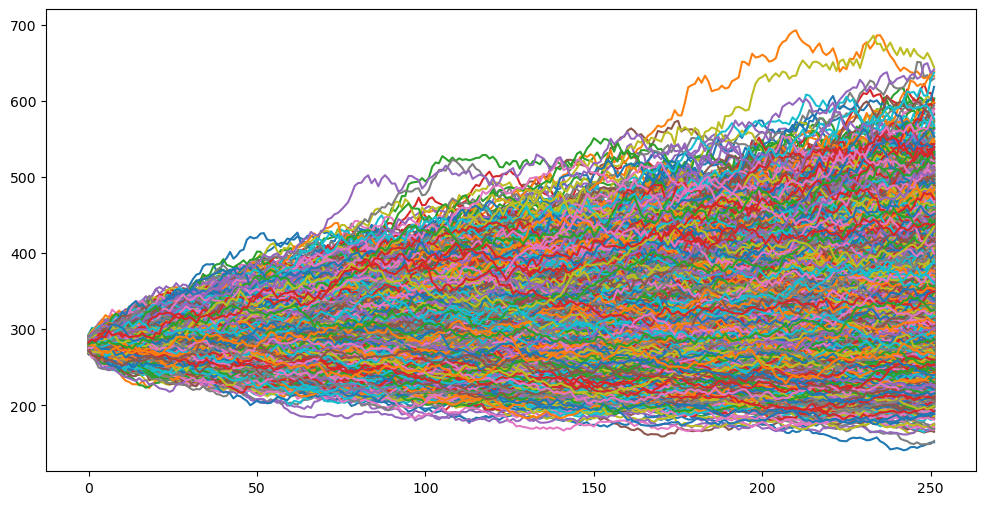

In [46]:
f = plt.figure(figsize=(12,6))

for price in tqdm(simulated_prices):
    plt.plot(price['data'])